## corv: Validations Off Of Falcon et al 2010

[GitHub Page](https://github.com/vedantchandra/corv)

---

Table Of Contents:

1. [Validation Without Templates](#validation-no-template)
2. [Validation With Templates](#db-no-template)

---

<a id="validation-no-template"></a>

**01. Fitting A DA White Dwarf Without Templates (Need to check/proofread)**

---

The following is an example using $\texttt{corv}$ to calculate radial velocities of DA white dwarfs. It does this by isolating a portion of the spectrum around each absorption line. Then, $\texttt{corv}$ generates a model. When fitting without templates, that model consists of the control parameters of each Voigt profile plus a parameter for radial velocity. Then, $\texttt{corv}$ fits each parameter.

In [1]:
# Install a pip package in the current Jupyter kernel


### General
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.colors as colors

import astropy
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join

from astroquery.sdss import SDSS

from tqdm import tqdm

import corv

print(corv.__file__)
#corv.sdss.make_catalogs()

koester_interp_da.pkl
could not find pickled WD models
/Users/vedantchandra/0_research/01_sdss5/006_build_corv/data/comm_cat/
star and exposure catalogs not found! check paths and run make_catalogs() if you want to use sdss functionality. otherwise ignore.
/home/arseneau/anaconda3/lib/python3.9/site-packages/corv-0.1-py3.9.egg/corv/__init__.py


In [2]:
catalog = Table.read('data/sed_radii.fits')
falcon = Table.read('data/falcon2010.fit')

catalog['corv_rv'] = -9999 * np.ones(len(catalog))
catalog['corv_erv'] = -9999 * np.ones(len(catalog))

In [3]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join_skycoord
from astropy import table

catalog['wd_pos'] = SkyCoord(catalog['ra'], catalog['dec'], unit='deg')
falcon['wd_pos'] = SkyCoord(falcon['_RA'], falcon['_DE'], unit='deg')

join_func = table.join_skycoord(5 * u.arcsecond)
falcon_xmatch = table.join(catalog, falcon, join_funcs={'wd_pos': join_skycoord(5 * u.arcsec)})

In [7]:
figs = []

for j in tqdm( range(len(falcon_xmatch))):
    p,m,f = np.array(falcon_xmatch['col_p_m_f'][j].split('-')).astype(float)
    
    try:
        xid = SDSS.query_specobj(plate = p, mjd = m, fiberID = f)
    except ValueError:
        print('unknown error')
        
    #if xid == None:
    #    print('object not found in SDSS... skipping...')
    #    continue
    try:
        sp = SDSS.get_spectra(matches=xid)
    except:
        print('http error')
        continue
    for i in range(len(sp[0:1])):
        wl = np.array(10**sp[i][1].data['loglam'])
        fl = np.array(sp[i][1].data['flux'])
        ivar = np.array(sp[i][1].data['ivar'])
        
        #print(catalog['teff'][j])
        
        corvmodel = corv.models.make_balmer_model(names = ['a','b','g','d'])
        param_res, rv_res, rv_init = corv.fit.fit_corv(wl, fl, ivar, corvmodel)
        #print(str(rv_res.params['RV'].value) + '+/-' + str(rv_res.params['RV'].stderr))
        
        #corv.utils.lineplot(wl, fl, ivar, corvmodel, rv_res.params, gap = 0.3, printparams = False, figsize = (6, 5))

        #f.suptitle('%d : %2.2f +/- %2.2f' % (i, rv_res.params['RV'].value, rv_res.params['RV'].stderr))
        #figs.append(f)
        
        
        
    falcon_xmatch['corv_rv'][j] = (rv_res.params['RV'].value)
    falcon_xmatch['corv_erv'][j] = (rv_res.params['RV'].stderr)

100%|███████████████████████████████████████████████████████████████████████████████████| 97/97 [01:11<00:00,  1.36it/s]


(-25.0, 75.0)

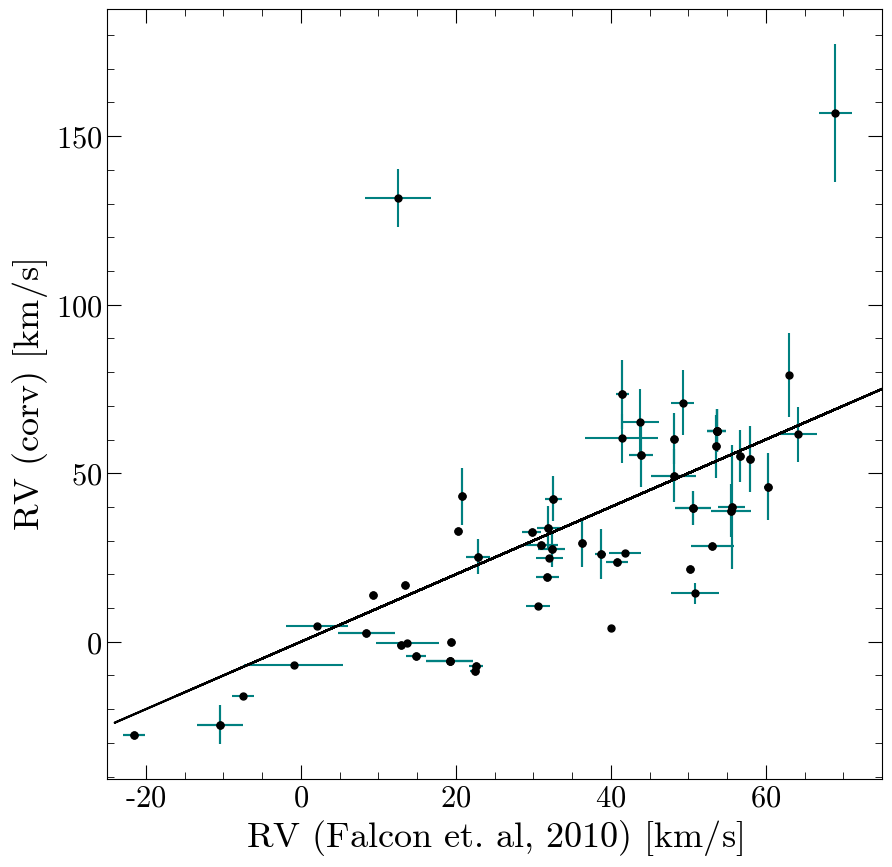

In [10]:
def linear(x):
    return x

plt.figure(figsize=(10,10))
plt.style.use('stefan.mplstyle')

plt.errorbar(falcon_xmatch['Adp-V'][np.abs(falcon_xmatch['corv_rv']) < 2500], falcon_xmatch['corv_rv'][np.abs(falcon_xmatch['corv_rv']) < 2500], 
             xerr = falcon_xmatch['e_Adp-V'][np.abs(falcon_xmatch['corv_rv']) < 2500], yerr = falcon_xmatch['corv_erv'][np.abs(falcon_xmatch['corv_rv']) < 2500],
             fmt='o', label = 'Data', color='black', ecolor = 'teal')
plt.plot(falcon_xmatch['vr'][np.abs(falcon_xmatch['corv_rv']) < 2500], linear(falcon_xmatch['vr'][np.abs(falcon_xmatch['corv_rv']) < 2500]), color = 'black')


ymin, ymax = plt.ylim()
plt.xlabel(r'RV (Falcon et. al, 2010) $[km/s]$')
plt.ylabel(r'RV (corv) $[km/s]$')

plt.xlim(-25, 75)